In [24]:
import pandas as pd

# Import Data from Bucket
from sagemaker import get_execution_role

role = get_execution_role()
#data_location = 's3://tweets-hackoff/label_tweets.csv'
#tweets = pd.read_csv(data_location)
#tweets
role = get_execution_role()
bucket = 'tweets-hackoff1'
prefix = 'sagemaker'
file = 'label_tweets.csv'
data_location = 's3://{}/{}/'.format(bucket, file)
tweets = pd.read_csv(data_location)
print('\nIAM Role: {}'.format(role))


IAM Role: arn:aws:iam::958187644922:role/service-role/AmazonSageMaker-ExecutionRole-20201212T195010


In [23]:
# Only take negative tweets
neg = tweets[(tweets.flag == 'negative')]
neg

,user_location,user_created,date,text,flag
5,Silicon Valley,2018-07-08 20:42:31,2020-12-12 04:17:54,"Alright fam, I need the sickest pictures of yo...",negative
14,Silicon Valley,2018-07-08 20:42:31,2020-12-12 01:48:45,".⁦@elonmusk⁩ ""We are fortunate to have the hig...",negative
23,"Oakland, CA",2008-07-29 22:29:44,2020-12-12 11:00:07,All eyes are on Texas after Tesla CEO Elon Mus...,negative
24,"Lafayette, CA",2008-11-28 00:36:42,2020-12-11 00:33:45,Anyone else sometimes drive with no audio on i...,negative
27,"San Francisco, CA",2009-09-17 23:52:55,2020-12-12 01:48:47,Tesla to replace Apartment Investment and Mana...,negative
...,...,...,...,...,...
4743,Freedom,2017-09-24 15:52:17,2020-12-11 10:25:07,#Tesla's growth is just insane. Will not sell ...,negative
4763,NaN,2011-11-02 19:08:02,2020-12-11 10:12:29,RT @ElectrekCo: Tesla Sentry mode captures own...,negative
4945,NaN,2013-12-05 07:52:16,2020-12-11 11:25:25,RT @gabriel_zucman: Amazon and Tesla do not di...,negative
4961,@CEDAWpt CEDAWpt.com,2008-09-03 13:24:49,2020-12-11 10:42:13,RT @gabriel_zucman: Amazon and Tesla do not di...,negative


In [7]:
#!pip install wordcloud

# Preprocessing
import nltk # Python library for NLP
nltk.download('stopwords')
nltk.download('wordnet')

import random                              # pseudo-random number generator
import re                                  # library for regular expression operations
import string                              # for string operations
from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer, SnowballStemmer    # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
class TweetClassify():

    def __init__(self, tweets_df, column_name , stemm = False, lemm =True):
        self.tweets_ = tweets_df
        self.stemm_ = stemm
        self.lemm_ = lemm
        self.lemmatizer_ = WordNetLemmatizer()
        
        self.stopwords_eng_ = nltk.corpus.stopwords.words('english')
        self.preprocess(column_name)
        
    def preprocess(self, column_name):
        self.tweets_['tweets_clean'] = self.tweets_[column_name].apply(lambda x: self.clean_text(x, stemm= self.stemm_, lemm = self.lemm_ ,stop_words = self.stopwords_eng_))


    def clean_text(self,observation,stemm , lemm , stop_words):
        #Clean tweets (removing punctuations and converting everything to lowercase)
        
        observation = re.sub(r'[^\$\w\s]', '', str(observation).lower().strip())
        observation = re.sub(r'^RT[\s]+', '', observation)
        observation = re.sub(r'https?:\/\/.*[\r\n]*', '', observation) # removing hyperlinks
        observation = re.sub(r'#', '', observation) #removing hash # sign


        #Tokenize (converting strings to lists)
        tokens_list = observation.split()
        tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
        tokens_list = tokenizer.tokenize(observation)
        #Remove the Stopwords
        stop_words = set(stop_words)
        stop_words.update(["tesla"])
        if stop_words is not None:
            stop_text = []
            for word in tokens_list: 
                if (word not in stop_words and  # remove stopwords
        word not in string.punctuation ): # remove punctuation
                    word_ = ''
                    for char in word:
                        if (char not in string.punctuation and
                            char not in ['1','2','3','4','5','6','7','8','9','0','',' ']):
                            word_ = "".join((word_,char))
                    stop_text.append(word_)
                    tokens_list = stop_text.copy()

        if lemm == True:
            lem_text = []
            for word in tokens_list: # Go through every word in the tokens list
                # Init the Wordnet Lemmatizer
                lem_word = self.lemmatizer_.lemmatize(word,'v')
                lem_text.append(lem_word)
            tokens_list = lem_text.copy()
        
        tweets_clean = " ".join(tokens_list)

        return tokens_list

In [9]:
tweets_processed = TweetClassify(neg, column_name='text')

In [10]:
neg

,user_location,user_created,date,text,flag,tweets_clean
5,Silicon Valley,2018-07-08 20:42:31,2020-12-12 04:17:54,"Alright fam, I need the sickest pictures of yo...",negative,"[alright, fam, need, sickest, picture, water, ..."
14,Silicon Valley,2018-07-08 20:42:31,2020-12-12 01:48:45,".⁦@elonmusk⁩ ""We are fortunate to have the hig...",negative,"[elonmusk, fortunate, highclass, problem, dema..."
23,"Oakland, CA",2008-07-29 22:29:44,2020-12-12 11:00:07,All eyes are on Texas after Tesla CEO Elon Mus...,negative,"[eye, texas, ceo, elon, musk, major, tech, com..."
24,"Lafayette, CA",2008-11-28 00:36:42,2020-12-11 00:33:45,Anyone else sometimes drive with no audio on i...,negative,"[anyone, else, sometimes, drive, audio, listen..."
27,"San Francisco, CA",2009-09-17 23:52:55,2020-12-12 01:48:47,Tesla to replace Apartment Investment and Mana...,negative,"[replace, apartment, investment, management, s..."
...,...,...,...,...,...,...
4743,Freedom,2017-09-24 15:52:17,2020-12-11 10:25:07,#Tesla's growth is just insane. Will not sell ...,negative,"[teslas, growth, insane, sell, single, share, ..."
4763,NaN,2011-11-02 19:08:02,2020-12-11 10:12:29,RT @ElectrekCo: Tesla Sentry mode captures own...,negative,"[rt, electrekco, sentry, mode, capture, owner,..."
4945,NaN,2013-12-05 07:52:16,2020-12-11 11:25:25,RT @gabriel_zucman: Amazon and Tesla do not di...,negative,"[rt, gabrielzucman, amazon, distribute, divide..."
4961,@CEDAWpt CEDAWpt.com,2008-09-03 13:24:49,2020-12-11 10:42:13,RT @gabriel_zucman: Amazon and Tesla do not di...,negative,"[rt, gabrielzucman, amazon, distribute, divide..."


## Vectorizing words count

In [11]:
# Create dictionary
wordfreq = {}
for sentence in neg['tweets_clean'].values:
    for word in sentence:
        if word not in wordfreq.keys():
            wordfreq[word] = 1
        else:
            wordfreq[word] += 1

In [12]:
# create
sentence_vectors = []
for sentence in neg['tweets_clean'].values:
    sent_vec = []
    for word in wordfreq.keys():
        if word in sentence:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    sentence_vectors.append(sent_vec)

In [13]:
import numpy as np
corpus = np.array(sentence_vectors)

In [14]:
vocabulary_size = len(corpus[0])

## Store the data on S3

In [16]:
import sagemaker
import os
import boto3
from sagemaker.serializers import NumpySerializer
from sagemaker.predictor import csv_serializer, json_deserializer

# separate the generated data into training and tests subsets
#num_documents_training = int(0.9*len(corpus))
#num_documents_test = len(corpus) - num_documents_training

#documents_training = corpus[:num_documents_training]
#documents_test = corpus[num_documents_training:]

# convert documents_training to Protobuf RecordIO format

np.savetxt('lda_train.csv', corpus, delimiter=',')

fname = 'lda_train.csv'
s3_object = os.path.join(prefix, 'train', fname)

boto3.Session().resource('s3').Bucket(bucket).Object(s3_object).upload_file('lda_train.csv')

s3_train_data_path = 's3://{}/{}'.format(bucket, s3_object)
print('Uploaded train data to {}'.format(s3_train_data_path))

Uploaded train data to S3: s3://tweets-hackoff1/sagemaker/train/lda_train.csv


## Training

In [17]:
# select the algorithm container based on this notebook's current location
containers = {
    'us-west-2': '266724342769.dkr.ecr.us-west-2.amazonaws.com/lda:latest',
    'us-east-1': '766337827248.dkr.ecr.us-east-1.amazonaws.com/lda:latest',
    'us-east-2': '999911452149.dkr.ecr.us-east-2.amazonaws.com/lda:latest',
    'eu-west-1': '999678624901.dkr.ecr.eu-west-1.amazonaws.com/lda:latest',
    'ap-northeast-1': '258307448986.dkr.ecr.ap-northeast-1.amazonaws.com/lda:latest'
}
region_name = boto3.Session().region_name
container = containers[region_name]

print('Using SageMaker LDA container: {} ({})'.format(container, region_name))

Using SageMaker LDA container: 766337827248.dkr.ecr.us-east-1.amazonaws.com/lda:latest (us-east-1)


In [20]:
session = sagemaker.Session()

# specify general training job information
lda = sagemaker.estimator.Estimator(
    container,
    role,
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    sagemaker_session=session,
)

# set algorithm-specific hyperparameters
lda.set_hyperparameters(
    num_topics=3,
    feature_dim=vocabulary_size,
    mini_batch_size=len(corpus),
    alpha0=1.0,
)

s3_train_data = sagemaker.session.s3_input(s3_data=s3_train_data_path, content_type='text/csv;label_size=0')

# run the training job on input data stored in S3
lda.fit({'train': s3_train_data})

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2020-12-13 02:39:32 Starting - Starting the training job...
2020-12-13 02:39:56 Starting - Launching requested ML instancesProfilerReport-1607827172: InProgress
.........
2020-12-13 02:41:17 Starting - Preparing the instances for training......
2020-12-13 02:42:07 Downloading - Downloading input data...
2020-12-13 02:43:01 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Using mxnet backend.
[12/13/2020 02:42:59 INFO 140603810699072] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'alpha0': u'1.0', u'max_restarts': u'10', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'allow_svd_init': u'true', u'epochs': u'1', u'tol': u'1e-8', u'_kvstore': u'local', u'max_iterations': u'1000'}
[12/13/2020 02:42:59 INFO 140603810699072] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'891', u'mini_batch_size'

In [21]:
print('Training job name: {}'.format(lda.latest_training_job.job_name))

Training job name: lda-2020-12-13-02-39-32-456


## Inference

In [ ]:
lda_inference = lda.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',  # LDA inference may work better at scale on ml.c4 instances
)

----------

In [19]:
print('Endpoint name: {}'.format(lda_inference.endpoint))

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: lda-2020-12-13-02-08-31-551


In [20]:
lda_inference.content_type = 'text/csv'

AttributeError: can't set attribute

In [21]:
results = lda_inference.predict(documents_test)

print(results)

ParamValidationError: Parameter validation failed:
Invalid type for parameter Body, value: [[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 1]], type: <class 'numpy.ndarray'>, valid types: <class 'bytes'>, <class 'bytearray'>, file-like object

In [ ]:
computed_topic_mixtures = np.array([prediction['topic_mixture'] for prediction in results['predictions']])

print(computed_topic_mixtures)

In [ ]:
print(topic_mixtures_test[0])      # known test topic mixture
print(computed_topic_mixtures[0])  # computed topic mixture (topics permuted)

In [22]:
sagemaker.Session().delete_endpoint(lda_inference.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


## K topics

Coherence Score = degree of semantic similarity between high scoring words in the topic

In [33]:
def coherence(dictionary, corpus, texts, start, stop):
    values = []
    models = []
    for num_topics in range(start, stop):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                                num_topics=num_topics,
                                                id2word=id2word,
                                               random_state=123,
                                               alpha='auto',
                                                eta='auto',
                                               per_word_topics=True)
        models.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        values.append(coherencemodel.get_coherence())

    return models, values

In [34]:
start=3
stop=9
models, values = coherence(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=processed_docs,
                                                        start=start, 
                                                        stop=stop)

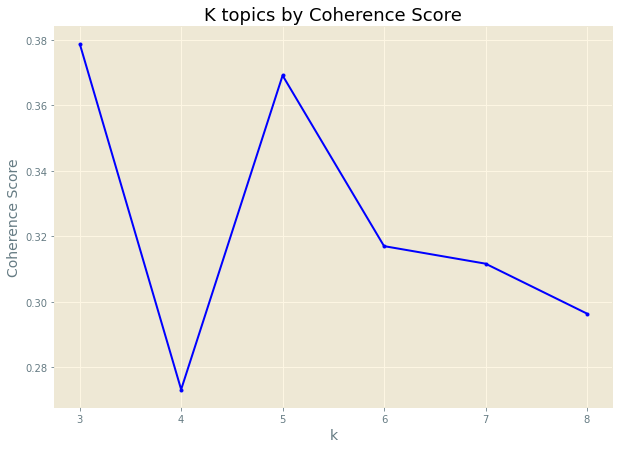

In [50]:
x = range(start, stop)
plt.figure(figsize=(10,7))
plt.style.use('Solarize_Light2')
plt.plot(x, values, color = "blue",marker=".")
plt.xlabel("k", size=14)
plt.ylabel("Coherence Score", size=14)
plt.title('K topics by Coherence Score',size=18)
plt.show()

## LDA model

In [51]:
k_topics = 3
rs = 42

In [52]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k_topics, 
                                           random_state=rs,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='auto',
                                           eta='auto',
                                           iterations=125,
                                           per_word_topics=True)
doc_lda = lda_model[corpus]

AttributeError: module 'pyLDAvis.gensim' has no attribute 'models'

In [38]:
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.034*"" + 0.013*"teslas" + 0.013*"german" + 0.011*"today" + '
  '0.011*"manufacture" + 0.011*"hide" + 0.011*"check" + 0.011*"court" + '
  '0.011*"easter" + 0.011*"egg"'),
 (1,
  '0.025*"" + 0.018*"people" + 0.018*"hide" + 0.011*"new" + '
  '0.011*"realteslanorth" + 0.011*"egg" + 0.011*"case" + 0.011*"easter" + '
  '0.011*"asians" + 0.011*"miss"'),
 (2,
  '0.037*"new" + 0.037*"" + 0.019*"auto" + 0.019*"snake" + 0.014*"next" + '
  '0.014*"company" + 0.014*"first" + 0.011*"las" + 0.011*"httpstcotbmwnjivo" + '
  '0.011*"month"')]


In [39]:
from string import punctuation
class ProcessTweet():

    def __init__(self,  stemm = False, lemm =True):
        #self.tweet_ = tweet
        self.stemm_ = stemm
        self.lemm_ = lemm
        self.stemmer_ = nltk.stem.SnowballStemmer('english')
        self.lemmatizer_ = nltk.stem.WordNetLemmatizer()
        self.vect_wc = feature_extraction.text.CountVectorizer(max_features = 10000, ngram_range=(1,2))
        self.vect_tfidf = feature_extraction.text.TfidfVectorizer(max_features = 10000, ngram_range=(1,2))
        self.stopwords_eng_ = nltk.corpus.stopwords.words('english')

    def preprocess(self, tweet):
        clean_tweet = self.clean_text(tweet, stemm= self.stemm_, lemm = self.lemm_ ,stop_words = self.stopwords_eng_)
        
        return clean_tweet

    def clean_text(self, observation, stemm, lemm, stop_words):
        #Clean tweets (removing punctuations and converting everything to lowercase)
        observation = re.sub(r'[^\$\w\s]', '', str(observation).lower().strip())
        observation = re.sub(r'^RT[\s]+', '', observation)
        observation = re.sub(r'https?:\/\/.*[\r\n]*', '', observation) # removing hyperlinks
        observation = re.sub(r'#', '', observation) #removing hash # sign

        #Tokenize (converting strings to lists)
        tokens_list = observation.split()
        tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
        tokens_list = tokenizer.tokenize(observation)
        #Remove the Stopwords
        stop_words = set(stop_words)
        stop_words.update(["american", "air","airline","thank","united","us","airways","virgin","america","jetblue","youre","extremely",
                     "usairway","usairways","flight","americanair","southwestair","southwestairlines","arbitrarily","dream","crazy",
                     "southwestairway","southwestairways","virginamerica","really","will","going","thanks","thankyou","passengersdont",
                     "please","got","let","take","help","already","never","now","told","guy","new","sure","still","amp","continue",
                     "plane","tell","ye","trying","yes","guy","much","appreciate", "thx","back","ok","good","credit","aacom",
                     "flying","love","great","awesome","see","nice","alway","httptcojwl26g6lrw","dontflythem","motherinlaw","night",
                     "nogearnotraining","seriously","didnt","coudnt","cant","wont","dont","wat","buffaloniagara","hasshe","morning",
                     "woulda","people","try","youve","youd","yours","flightled","tomorrow","today","wat","jfkyou","flite","cause",
                     "flightr","flight","need","hours","nooooo","like","doesnt","right","talk","tweet","mention","pbijfk","ridiculuous",
                     "wasnt","suppose","want","understand","come","work","worse","treat","think","know","worst","paulo","staduim",
                     "wouldnt","stay","away","wont","werent","happen","sorry","havent","tonight","drive","life","thing","aa951",
                     "whats","theyre","better","thats","allow","hope","stop","cool","niece","happy","word","customercant",
                     "suck","sunday","monday","tuesday","wednesday","thursday","friday","saturday","weekend","ruin","shouldnt",
                     "miami","los angeles","new york","chicago","dallas","apparently","itover","someones","savannah","lucymay",
                     "betterother","instead","look","hopefully","yesterday","antonio","unacceptable","folks","record",'arent',
                     "miss","hang","wrong","stick","grind","tarmac","theres","forget","terrible","clothe","terrible","break",
                     "actually","frustrate","correct","ridiculous","expect","different","pathetic","bother","follow","fault",
                     "impossible","point","cover","person","ask","speak","things","earlier","mean","select","minutes",
                     "unite","horrible","country","leave","speak","apologize","faster","hop","confuse","lose","flightd","hear",
                     "literally","years","surprise","bump","fail","compensate","hand","helpful","upset","friend","excuse","claim",
                     "situation","multiple","weather","choose","company","believe","question","kick","anymore","awful","delta",
                      "dozen","medical","completely","finally", "waste","shock","annoy","maybe","strand","mess","finally",
                      "plan","place","apology","center","plan","twitter","promise","prefer","count","maybe","shock","longer","meet",
                         "important","drop"])
        if stop_words is not None:
            stop_text = []
            for word in tokens_list: 
                if (word not in stop_words and  # remove stopwords
        word not in punctuation ): # remove punctuation
                    word_ = ''
                    for char in word:
                        if (char not in punctuation and
                            char not in ['1','2','3','4','5','6','7','8','9','0','',' ']):
                            word_ = "".join((word_,char))
                    stop_text.append(word_)
                    tokens_list = stop_text.copy()
        if stemm == True:
            stem_text = []
            for word in tokens_list: # Go through every word in the tokens list
                # Init the Stemmer
                stem_word = self.stemmer_.stem(word)
                stem_text.append(stem_word)
            tokens_list = stem_text.copy()
        if lemm == True:
            lem_text = []
            for word in tokens_list: # Go through every word in the tokens list
                # Init the Wordnet Lemmatizer
                lem_word = self.lemmatizer_.lemmatize(word)
                lem_text.append(lem_word)
            tokens_list = lem_text.copy()
        return tokens_list

In [42]:
id2word = corpora.Dictionary.load('id2word.dict')

message = '''Tesla is not designing a premium leather only car interior!!!
                    '''
clean_class = ProcessTweet()
clean_tweet = clean_class.preprocess(message)
clean_tweet

['tesla', 'designing', 'premium', 'leather', 'car', 'interior']

In [43]:
bow_vector = id2word.doc2bow(clean_tweet)
result = lda_model.get_document_topics(bow_vector)
resultdict = dict(result)

In [44]:
resultdict

{0: 0.024463305, 1: 0.92601436, 2: 0.04952237}

In [46]:
orddict = sorted(resultdict, key=resultdict.get, reverse=True)
Keymax = 1
if resultdict[orddict[0]]-resultdict[orddict[1]] <=.08:
    Keymax +=orddict[1]
    print("Predicted topic: ",orddict[1]+1)
    print("Probability Score: ",resultdict[orddict[1]])
else:
    Keymax +=orddict[0]
    print("Predicted topic: ",orddict[0]+1)
    print("Probability Score: ",resultdict[orddict[0]])

#Keymax = max(resultdict, key=resultdict.get)+1
#print("Predicted Topic :", Keymax) 


if Keymax == 1:
    print('Topic 1')
elif Keymax == 2:
    print('Topic 2')
elif Keymax == 3:
    print('Topic 3')
else:
    print('Other')
print("\n")

for index, score in resultdict.items():
    print("Score: {}\n Topic: {}\n Keywords:{} \n".format(score, index+1, lda_model.print_topic(index)))

Predicted topic:  2
Probability Score:  0.92601436
Topic 2


Score: 0.02446330524981022
 Topic: 1
 Keywords:0.034*"" + 0.013*"teslas" + 0.013*"german" + 0.011*"today" + 0.011*"manufacture" + 0.011*"hide" + 0.011*"check" + 0.011*"court" + 0.011*"easter" + 0.011*"egg" 

Score: 0.9260143637657166
 Topic: 2
 Keywords:0.025*"" + 0.018*"people" + 0.018*"hide" + 0.011*"new" + 0.011*"realteslanorth" + 0.011*"egg" + 0.011*"case" + 0.011*"easter" + 0.011*"asians" + 0.011*"miss" 

Score: 0.04952237010002136
 Topic: 3
 Keywords:0.037*"new" + 0.037*"" + 0.019*"auto" + 0.019*"snake" + 0.014*"next" + 0.014*"company" + 0.014*"first" + 0.011*"las" + 0.011*"httpstcotbmwnjivo" + 0.011*"month" 



## Visualize 

In [47]:

import pyLDAvis
from pyLDAvis import gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word,sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.043202 -0.041332       1        1  25.378268
1     -0.059455  0.037188       2        1  29.896048
2      0.102657  0.004144       3        1  44.725684, topic_info=              Term      Freq     Total Category  logprob  loglift
58             new  4.000000  4.000000  Default  30.0000  30.0000
94          people  1.000000  1.000000  Default  29.0000  29.0000
55            hide  1.000000  1.000000  Default  28.0000  28.0000
54             egg  1.000000  1.000000  Default  27.0000  27.0000
51            case  1.000000  1.000000  Default  26.0000  26.0000
..             ...       ...       ...      ...      ...      ...
160          softw  0.934308  1.339357   Topic3  -4.5465   0.4445
158        problem  0.934308  1.339357   Topic3  -4.5465   0.4445
157  httpstcosaaoc  0.934308  1.339357   Topic3  -4.5465   0.4445
50                  3.246404  6.415585   Topic3  -3.3010   0.1234
33            next  1.254369  2.076948   Topic3  -4.2519   0.3004

[147 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
50        1  0.311741        
50        2  0.155870        
50        3  0.467611        
84        2  1.014546   asian
85        2  1.014546  asians
...     ...       ...     ...
112       3  0.746627      vz
25        2  1.014546       w
95        2  1.014546   women
13        1  1.057685    year
61        2  1.014546     zyv

[123 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])